In [1]:
!pip install grad-cam
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=ae7a9256c821ab11440251ddd184421ff86247189faef392ce03b1ae19909cc6
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 27.7 MB/s eta 0:00:00


In [2]:
# --------- 1) KAGGLE DOWNLOAD (HAM10000) ---------
# Upload kaggle.json once when prompted

from google.colab import files
import os, zipfile, glob
import pandas as pd

# Step 1: Upload kaggle.json
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("👉 Please upload kaggle.json (from your Kaggle account settings).")
    uploaded = files.upload()  # upload kaggle.json
    os.makedirs("/root/.kaggle", exist_ok=True)
    for k, v in uploaded.items():
        with open("/root/.kaggle/kaggle.json", "wb") as f:
            f.write(v)
    os.chmod("/root/.kaggle/kaggle.json", 0o600)

# Step 2: Install Kaggle CLI
!pip -q install kaggle

# Step 3: Download HAM10000 dataset
DATA_DIR = "/content/ham10000"
os.makedirs(DATA_DIR, exist_ok=True)
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p "{DATA_DIR}" -o

# Step 4: Unzip everything
zip_files = glob.glob(f"{DATA_DIR}/*.zip")
for z in zip_files:
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)

print("✅ Dataset downloaded and extracted!")
print("Files in DATA_DIR:", os.listdir(DATA_DIR))

# Step 5: Fix folder names if needed
IMG_DIRS = [os.path.join(DATA_DIR, "ham10000_images_part_1"),
            os.path.join(DATA_DIR, "ham10000_images_part_2")]
for d in IMG_DIRS:
    if not os.path.exists(d):
        alt = os.path.join(DATA_DIR, d.split("/")[-1].upper())
        if os.path.exists(alt):
            os.rename(alt, d)

# Step 6: Load metadata
META_CSV = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
assert os.path.exists(META_CSV), "HAM10000_metadata.csv not found!"
meta = pd.read_csv(META_CSV)
print("Metadata preview:")
print(meta.head())


👉 Please upload kaggle.json (from your Kaggle account settings).


Saving kaggle (1).json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [02:08<00:00, 37.9MB/s]
100% 5.20G/5.20G [02:08<00:00, 43.6MB/s]
✅ Dataset downloaded and extracted!
Files in DATA_DIR: ['HAM10000_images_part_1', 'ham10000_images_part_2', 'skin-cancer-mnist-ham10000.zip', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']
Metadata preview:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [17]:
# =========================
# Part 2: Data Splits
# =========================
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# -------------------------
# Paths
# -------------------------
DATA_DIR = "/content/ham10000"  # Where you downloaded the dataset
META_CSV = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
ARTIFACTS_DIR = "/content/drive/MyDrive/ham10000_mm_robust"  # Save splits and models here
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# -------------------------
# Load metadata
# -------------------------
meta = pd.read_csv(META_CSV)
print("Metadata preview:")
print(meta.head())

# -------------------------
# Split: train 70%, valid 15%, test 15%
# -------------------------
train_ids, temp_ids, train_labels, temp_labels = train_test_split(
    meta["image_id"], meta["dx"],
    test_size=0.3, stratify=meta["dx"], random_state=42
)

valid_ids, test_ids, valid_labels, test_labels = train_test_split(
    temp_ids, temp_labels,
    test_size=0.5, stratify=temp_labels, random_state=42
)

# -------------------------
# Save splits
# -------------------------
splits = {
    "train": train_ids.tolist(),
    "valid": valid_ids.tolist(),
    "test": test_ids.tolist()
}

splits_path = os.path.join(ARTIFACTS_DIR, "splits.json")
with open(splits_path, "w") as f:
    json.dump(splits, f, indent=4)

print(f"✅ Splits saved at: {splits_path}")

# -------------------------
# Map splits to dataframes
# -------------------------
train_df = meta[meta["image_id"].isin(splits["train"])]
valid_df = meta[meta["image_id"].isin(splits["valid"])]
test_df  = meta[meta["image_id"].isin(splits["test"])]

print(f"Split sizes: Train={len(train_df)}, Valid={len(valid_df)}, Test={len(test_df)}")


Metadata preview:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
✅ Splits saved at: /content/drive/MyDrive/ham10000_mm_robust/splits.json
Split sizes: Train=7010, Valid=1502, Test=1503


In [20]:
# -------------------------
# Part 3: Dataset & DataLoader Setup
# -------------------------

import os
import glob
import json
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

# -------------------------
# Paths
# -------------------------
ARTIFACTS_DIR = "/content/drive/MyDrive/ham10000_mm_robust/20250820_052510"
DATA_DIR = "/content/ham10000"
META_CSV = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMG_DIRS = [os.path.join(DATA_DIR, "HAM10000_images_part_1"),
            os.path.join(DATA_DIR, "HAM10000_images_part_2")]

# -------------------------
# Load metadata
# -------------------------
meta = pd.read_csv(META_CSV)

# -------------------------
# Train / Val / Test split
# -------------------------
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(meta["image_id"], test_size=0.3, random_state=42, stratify=meta["dx"])
valid_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42, stratify=meta.loc[meta["image_id"].isin(test_ids), "dx"])

splits = {"train": train_ids.tolist(), "valid": valid_ids.tolist(), "test": test_ids.tolist()}

# Save splits
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
with open(os.path.join(ARTIFACTS_DIR, "splits.json"), "w") as f:
    json.dump(splits, f)

print(f"Train: {len(train_ids)}, Valid: {len(valid_ids)}, Test: {len(test_ids)}")
print("Splits saved to:", os.path.join(ARTIFACTS_DIR, "splits.json"))

# -------------------------
# Albumentations transforms (corrected for v2.x)
# -------------------------
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.3),
    A.GaussNoise(p=0.2),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    ToTensorV2()
])

# -------------------------
# Dataset Class
# -------------------------
class HAM10000Dataset(Dataset):
    def __init__(self, df, img_dirs, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dirs = img_dirs
        self.transform = transform
        self.id_to_file = self._build_file_index()

    def _build_file_index(self):
        index = {}
        for d in self.img_dirs:
            for f in os.listdir(d):
                if f.endswith(".jpg"):
                    index[f.split(".")[0]] = os.path.join(d, f)
        return index

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        dx = row["dx"]
        img_path = self.id_to_file.get(img_id)
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        # Map disease labels to integer indices
        label_map = {cls: i for i, cls in enumerate(sorted(self.df["dx"].unique()))}
        label = label_map[dx]

        return image, label

# -------------------------
# Create datasets and dataloaders
# -------------------------
train_df = meta[meta["image_id"].isin(splits["train"])]
valid_df = meta[meta["image_id"].isin(splits["valid"])]
test_df  = meta[meta["image_id"].isin(splits["test"])]

train_dataset = HAM10000Dataset(train_df, IMG_DIRS, transform=train_transform)
valid_dataset = HAM10000Dataset(valid_df, IMG_DIRS, transform=val_transform)
test_dataset  = HAM10000Dataset(test_df, IMG_DIRS, transform=val_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders ready. Examples per batch:", BATCH_SIZE)


Train: 7010, Valid: 1502, Test: 1503
Splits saved to: /content/drive/MyDrive/ham10000_mm_robust/20250820_052510/splits.json
DataLoaders ready. Examples per batch: 32


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [22]:
# After creating train/valid/test splits
class_names = sorted(meta["dx"].unique())
print("Classes:", class_names)


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [25]:
# ---------------------- Part 4: Model & Training Setup ----------------------

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----- Class names -----
class_names = sorted(meta["dx"].unique())  # from Part 3
NUM_CLASSES = len(class_names)
print("Number of classes:", NUM_CLASSES)

# ----- Dataset -----
IMG_DIRS = [os.path.join(DATA_DIR, "HAM10000_images_part_1"),
            os.path.join(DATA_DIR, "HAM10000_images_part_2")]

class HAM10000Dataset(Dataset):
    def __init__(self, df, img_dirs, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dirs = img_dirs
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]

        # Search in both folders
        for d in self.img_dirs:
            img_path = os.path.join(d, img_id + ".jpg")
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f"Image {img_id} not found in any folder.")

        image = Image.open(img_path).convert("RGB")
        label = class_names.index(row["dx"])

        if self.transform:
            image = self.transform(image)

        return image, label

# ----- Transforms -----
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),  # converts to float32 and scales 0-1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----- DataLoaders -----
train_dataset = HAM10000Dataset(train_df, IMG_DIRS, transform=train_transform)
valid_dataset = HAM10000Dataset(valid_df, IMG_DIRS, transform=val_transform)
test_dataset  = HAM10000Dataset(test_df, IMG_DIRS, transform=val_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"DataLoaders ready. Examples per batch: {BATCH_SIZE}")

# ----- Model -----
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  # Replace classifier
model = model.to(device)

# ----- Loss & Optimizer -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ----- Training parameters -----
EPOCHS = 25

# ----- Save directory -----
ARTIFACTS_DIR = "/content/drive/MyDrive/ham10000_mm_robust/052510"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

print("Part 4 setup complete ✅")


Device: cuda
Number of classes: 7
DataLoaders ready. Examples per batch: 32


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Part 4 setup complete ✅


In [26]:
# -------------------- Part 5: Training --------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----- Number of classes -----
NUM_CLASSES = len(class_names)  # from Part 3

# ----- Model: Pretrained ResNet50 -----
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# Replace the final layer
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

# ----- Loss and Optimizer -----
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ----- Training parameters -----
EPOCHS = 25
best_val_acc = 0.0
model_save_path = "/content/drive/MyDrive/ham10000_mm_robust/20250820_052510/best_model.pth"

# ----- Training Loop -----
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        # Convert images to float tensor
        imgs = imgs.float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100

    # ----- Validation -----
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in valid_loader:
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total * 100

    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ New best model saved with Val Acc: {best_val_acc:.2f}%")

    # Step the scheduler
    scheduler.step()

print("Training complete! Best validation accuracy:", best_val_acc)


Device: cuda


Epoch 1/25 - Training: 100%|██████████| 220/220 [01:24<00:00,  2.59it/s]


Epoch 1/25: Train Loss: 0.6832, Train Acc: 75.31%, Val Acc: 79.09%
✅ New best model saved with Val Acc: 79.09%


Epoch 2/25 - Training: 100%|██████████| 220/220 [01:12<00:00,  3.02it/s]


Epoch 2/25: Train Loss: 0.4768, Train Acc: 82.54%, Val Acc: 81.56%
✅ New best model saved with Val Acc: 81.56%


Epoch 3/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.98it/s]


Epoch 3/25: Train Loss: 0.3870, Train Acc: 85.91%, Val Acc: 85.75%
✅ New best model saved with Val Acc: 85.75%


Epoch 4/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.97it/s]


Epoch 4/25: Train Loss: 0.3269, Train Acc: 88.29%, Val Acc: 85.22%


Epoch 5/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.97it/s]


Epoch 5/25: Train Loss: 0.2756, Train Acc: 89.86%, Val Acc: 85.35%


Epoch 6/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.95it/s]


Epoch 6/25: Train Loss: 0.2333, Train Acc: 91.34%, Val Acc: 82.96%


Epoch 7/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.96it/s]


Epoch 7/25: Train Loss: 0.2207, Train Acc: 92.00%, Val Acc: 86.09%
✅ New best model saved with Val Acc: 86.09%


Epoch 8/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.95it/s]


Epoch 8/25: Train Loss: 0.1099, Train Acc: 96.53%, Val Acc: 88.68%
✅ New best model saved with Val Acc: 88.68%


Epoch 9/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.98it/s]


Epoch 9/25: Train Loss: 0.0707, Train Acc: 97.96%, Val Acc: 88.48%


Epoch 10/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.96it/s]


Epoch 10/25: Train Loss: 0.0612, Train Acc: 98.10%, Val Acc: 88.88%
✅ New best model saved with Val Acc: 88.88%


Epoch 11/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.98it/s]


Epoch 11/25: Train Loss: 0.0511, Train Acc: 98.52%, Val Acc: 87.75%


Epoch 12/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.96it/s]


Epoch 12/25: Train Loss: 0.0438, Train Acc: 98.72%, Val Acc: 89.01%
✅ New best model saved with Val Acc: 89.01%


Epoch 13/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.98it/s]


Epoch 13/25: Train Loss: 0.0404, Train Acc: 98.83%, Val Acc: 88.55%


Epoch 14/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.96it/s]


Epoch 14/25: Train Loss: 0.0348, Train Acc: 98.97%, Val Acc: 88.68%


Epoch 15/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.96it/s]


Epoch 15/25: Train Loss: 0.0304, Train Acc: 99.24%, Val Acc: 89.55%
✅ New best model saved with Val Acc: 89.55%


Epoch 16/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.99it/s]


Epoch 16/25: Train Loss: 0.0258, Train Acc: 99.32%, Val Acc: 89.35%


Epoch 17/25 - Training: 100%|██████████| 220/220 [01:15<00:00,  2.93it/s]


Epoch 17/25: Train Loss: 0.0301, Train Acc: 99.19%, Val Acc: 89.41%


Epoch 18/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.98it/s]


Epoch 18/25: Train Loss: 0.0266, Train Acc: 99.33%, Val Acc: 88.88%


Epoch 19/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.97it/s]


Epoch 19/25: Train Loss: 0.0266, Train Acc: 99.36%, Val Acc: 88.95%


Epoch 20/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  3.01it/s]


Epoch 20/25: Train Loss: 0.0253, Train Acc: 99.39%, Val Acc: 89.15%


Epoch 21/25 - Training: 100%|██████████| 220/220 [01:14<00:00,  2.97it/s]


Epoch 21/25: Train Loss: 0.0218, Train Acc: 99.60%, Val Acc: 89.21%


Epoch 22/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  3.01it/s]


Epoch 22/25: Train Loss: 0.0238, Train Acc: 99.56%, Val Acc: 88.95%


Epoch 23/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.98it/s]


Epoch 23/25: Train Loss: 0.0245, Train Acc: 99.30%, Val Acc: 89.48%


Epoch 24/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  2.98it/s]


Epoch 24/25: Train Loss: 0.0243, Train Acc: 99.51%, Val Acc: 89.15%


Epoch 25/25 - Training: 100%|██████████| 220/220 [01:13<00:00,  3.00it/s]


Epoch 25/25: Train Loss: 0.0257, Train Acc: 99.29%, Val Acc: 89.55%
Training complete! Best validation accuracy: 89.54727030625833


Validation Accuracy: 89.55%
Test Accuracy: 89.75%


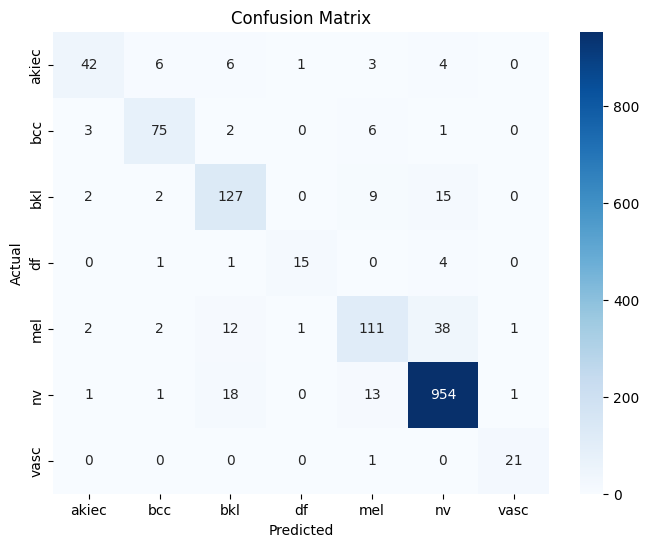

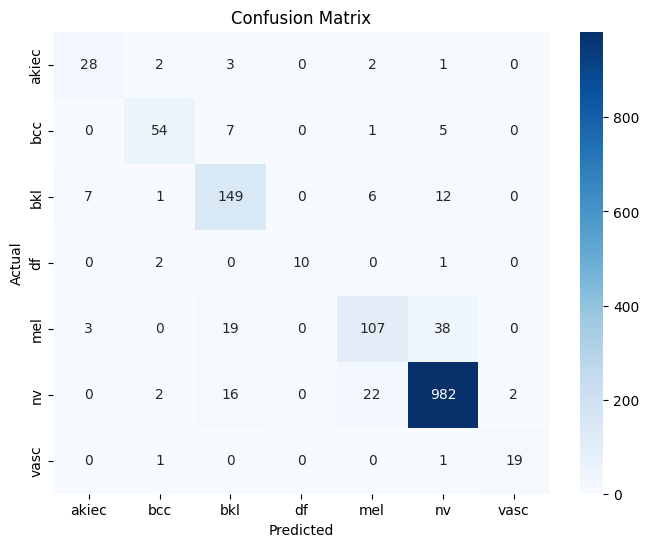

In [29]:
# --------- Part 6: Evaluation & Grad-CAM ---------
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np

# --------- Prepare device ---------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# --------- Evaluation function ---------
def evaluate_model(model, loader):
    y_true = []
    y_pred = []
    y_pred_proba = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device).float(), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return np.array(y_true), np.array(y_pred), np.array(y_pred_proba), report

# --------- DataLoaders (from Part 3) ---------
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# --------- Evaluate on validation and test sets ---------
y_true_val, y_pred_val, y_pred_proba_val, val_report = evaluate_model(model, valid_loader)
y_true_test, y_pred_test, y_pred_proba_test, test_report = evaluate_model(model, test_loader)

print("Validation Accuracy: {:.2f}%".format(100*np.mean(y_true_val == y_pred_val)))
print("Test Accuracy: {:.2f}%".format(100*np.mean(y_true_test == y_pred_test)))

# --------- Confusion Matrix ---------
def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(y_true_val, y_pred_val, class_names, save_path=os.path.join(ARTIFACTS_DIR, "confusion_matrix_val.png"))
plot_confusion_matrix(y_true_test, y_pred_test, class_names, save_path=os.path.join(ARTIFACTS_DIR, "confusion_matrix_test.png"))

# --------- Grad-CAM Visualization ---------
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

# Choose target layer (last ResNet layer)
target_layer = model.layer4[-1]

cam = GradCAM(model=model, target_layers=[target_layer])


def visualize_gradcam(img_path, model, cam, class_names):
    image = cv2.imread(img_path)[:,:,::-1]  # BGR to RGB
    img_input = transform(image).unsqueeze(0).to(device).float()  # transform from Part 3
    targets = None  # default: highest predicted class

    grayscale_cam = cam(input_tensor=img_input, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(image/255.0, grayscale_cam)
    plt.figure(figsize=(6,6))
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

# Example Grad-CAM
# visualize_gradcam("/content/ham10000/ham10000_images_part_1/ISIC_0027419.jpg", model, cam, class_names)


In [30]:
# Save the trained model
MODEL_PATH = os.path.join(ARTIFACTS_DIR, "resnet50_ham10000.pth")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Trained model saved at: {MODEL_PATH}")


Trained model saved at: /content/drive/MyDrive/ham10000_mm_robust/052510/resnet50_ham10000.pth


In [31]:
# ---------------- Part 7: Evaluation & Metrics Visualization ----------------
import os
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

results_dir = os.path.join(ARTIFACTS_DIR, "metrics_results")
os.makedirs(results_dir, exist_ok=True)

# Make sure model is in eval mode
model.eval()

def evaluate_model(model, loader, class_names):
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs.float())
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    return np.array(all_labels), np.array(all_preds), np.array(all_probs), report

# Evaluate on validation and test
y_true_val, y_pred_val, y_proba_val, val_report = evaluate_model(model, valid_loader, class_names)
y_true_test, y_pred_test, y_proba_test, test_report = evaluate_model(model, test_loader, class_names)

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig(save_path)
    plt.close()

plot_confusion_matrix(y_true_val, y_pred_val, class_names, os.path.join(results_dir, "confusion_matrix_val.png"))
plot_confusion_matrix(y_true_test, y_pred_test, class_names, os.path.join(results_dir, "confusion_matrix_test.png"))

# ROC curves per class
def plot_roc(y_true, y_proba, classes, save_path):
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_proba[:, i])
        auc = roc_auc_score(y_true == i, y_proba[:, i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig(save_path)
    plt.close()

plot_roc(y_true_val, y_proba_val, class_names, os.path.join(results_dir, "roc_curve_val.png"))
plot_roc(y_true_test, y_proba_test, class_names, os.path.join(results_dir, "roc_curve_test.png"))

# Save classification reports as JSON
import json
with open(os.path.join(results_dir, "classification_report_val.json"), "w") as f:
    json.dump(val_report, f, indent=4)
with open(os.path.join(results_dir, "classification_report_test.json"), "w") as f:
    json.dump(test_report, f, indent=4)

print("✅ Confusion matrices, ROC curves, and classification reports saved.")


✅ Confusion matrices, ROC curves, and classification reports saved.


In [42]:
import os

ARTIFACTS_DIR = "/content/drive/MyDrive/ham10000_mm_robust/20250820_052510"
print(os.listdir(ARTIFACTS_DIR))


['best_model.pth', 'splits.json']


In [49]:
import os

ARTIFACTS_DIR = "/content/drive/MyDrive/ham10000_mm_robust/052510"
print(os.listdir(ARTIFACTS_DIR))


['resnet50_ham10000.pth', 'confusion_matrix_val.png', 'metrics_results', 'confusion_matrix_test.png']


In [ ]:
import pandas as pd
META_PATH = "/content/ham10000/HAM10000_metadata.csv"
meta = pd.read_csv(META_PATH)


In [12]:
# -------------------------
# Part 8: Evaluation, Confusion Matrix & Grad-CAM
# -------------------------

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

# ------------------------- Class names -------------------------
class_names = sorted(meta["dx"].unique())  # Fix for NameError

# Make sure grad-cam is installed
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
except:
    !pip install grad-cam
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image


NameError: name 'meta' is not defined